### Data Analysis Pipeline

- **Create Simulation**: Represent Intermediate and weak selection.
- **Leverage Pre-trained Model**: Use Baseline Imagene CNN architecture
- **Training Regimen**:
  - Train for 10 epochs.
  - 10 epochs each from batches 1-9 of training data.
  - Test on the final batch of unseen data.
- **40k Simulations used**




In [1]:
!git clone https://github.com/Djinho/EvoNet-CNN-Insight.git

# Navigate to the cloned repository
%cd EvoNet-CNN-Insight/model_training/intermediate_weak

Cloning into 'EvoNet-CNN-Insight'...
remote: Enumerating objects: 5771, done.
remote: Counting objects: 100% (1392/1392), done.
remote: Compressing objects: 100% (909/909), done.
remote: Total 5771 (delta 541), reused 1305 (delta 466), pack-reused 4379
Receiving objects: 100% (5771/5771), 8.07 GiB | 44.58 MiB/s, done.
Resolving deltas: 100% (2139/2139), done.
Updating files: 100% (222/222), done.
/content/EvoNet-CNN-Insight/model_training/intermediate_weak


In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, activations, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_fscore_support, confusion_matrix

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")


# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Run ImaGene.py

In [3]:
%run -i ../../ImaGene.py

In [ ]:
#run to make simulations
import subprocess
subprocess.call("bash ../../generate_dataset.sh params_intermediate_weak.txt".split());

 the first iteration of training.


In [4]:

path_sim = './'

In [5]:
file_sim = ImaFile(simulations_folder=path_sim + 'IW/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

Then, we populate an _ImaGene_ object by specifying the variable we want to estimate/predict (`selection_coeff_hetero`) and how many data points per class we wish to retain.
As a quick example, we will use only 2000 data points per class.

In [6]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000);

We can have a look at the data stored in this object.

In [7]:
gene_sim.summary();

An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 161, max 456, mean 308.637500, std 53.323856


In [8]:
# Filter simulations based on frequency threshold of 0.01
gene_sim.filter_freq(0.01)

# Sort simulations by row frequency
gene_sim.sort('rows_freq')

# Provide summary of the simulation data
gene_sim.summary()
# Resize simulation data to (198, 192)
gene_sim.resize((198, 192))

# Provide summary of the simulation data
gene_sim.summary()
# Convert simulation data with data augmentation (flip)
gene_sim.convert(flip=True)

# Provide summary of the simulation data
gene_sim.summary()


An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 91, max 372, mean 224.415250, std 49.147078
An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000
An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0

information on the corresponding targets (in this case the selection coefficient, either 0 or selection coefficient of choice in $2N_e$ units with $N_e = 10000$).

0


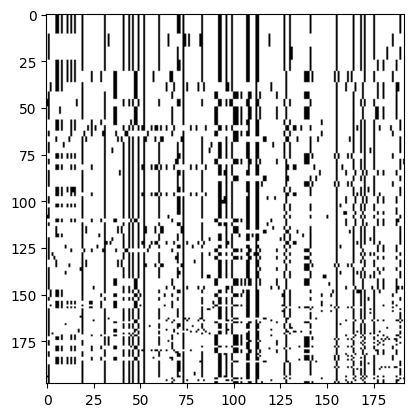

100


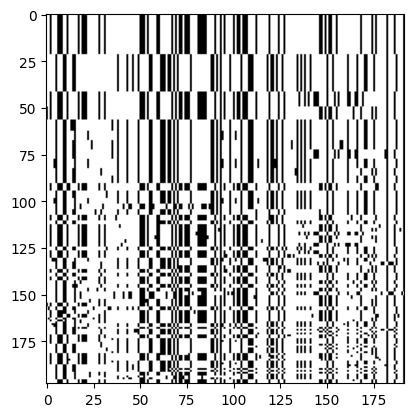

In [9]:
for sel in gene_sim.classes:
    print(sel)
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])

In [10]:
# Subset the simulation data with random indices
gene_sim.subset(get_index_random(gene_sim))

# Convert targets to binary format
gene_sim.targets = to_binary(gene_sim.targets)


Transfer Learning with VGG16 model
> Applied the data augmentation

In [11]:
model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Print the summary of the model to see its architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 196, 190, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 98, 95, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 93, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,145,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,173,473 (15.92 MB)

 Trainable params: 4,173,473 (15.92 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=10, verbose=1, validation_split=0.20)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.5479 - loss: 6.2755 - val_accuracy: 0.5175 - val_loss: 2.8520
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5567 - loss: 2.3280 - val_accuracy: 0.5738 - val_loss: 1.3394
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6666 - loss: 1.1940 - val_accuracy: 0.7975 - val_loss: 0.8868
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7469 - loss: 0.8959 - val_accuracy: 0.7262 - val_loss: 0.8090
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7520 - loss: 0.8018 - val_accuracy: 0.8400 - val_loss: 0.6900
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7909 - loss: 0.7356 - val_accuracy: 0.8612 - val_loss: 0.6238
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7932 - loss: 0.7124 - val_accuracy: 0.8450 - val_loss: 0.6124
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7939 - loss: 0.6660 - val_accuracy: 0.8388 - 

In [13]:
net_LCT = ImaNet(name='Imagene_Baseline_ARC')


In [14]:
net_LCT.update_scores(score);

In [15]:

i = 2
all_scores = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

i = 2
while i < 10:

    print(i)

    file_sim = ImaFile(simulations_folder=path_sim + 'IW/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    gene_sim.subset(get_index_random(gene_sim))
    gene_sim.targets = to_binary(gene_sim.targets)

    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=10, verbose=1, validation_split=0.20)

    # Append scores to all_scores dictionary
    all_scores['loss'].extend(score.history['loss'])
    all_scores['val_loss'].extend(score.history['val_loss'])
    all_scores['accuracy'].extend(score.history['accuracy'])
    all_scores['val_accuracy'].extend(score.history['val_accuracy'])

    i += 1


2
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7808 - loss: 0.6918 - val_accuracy: 0.8350 - val_loss: 0.5977
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8017 - loss: 0.6538 - val_accuracy: 0.8375 - val_loss: 0.5912
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8044 - loss: 0.6428 - val_accuracy: 0.8313 - val_loss: 0.5848
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8036 - loss: 0.6323 - val_accuracy: 0.8313 - val_loss: 0.5790
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8057 - loss: 0.6232 - val_accuracy: 0.8288 - val_loss: 0.5735
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8089 - loss: 0.6127 - val_accuracy: 0.8300 - val_loss: 0.5686
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8120 - loss: 0.6023 - val_accuracy: 0.8275 - val_loss: 0.5631
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8154 - loss: 0.5940 - val_accuracy: 0.8275 -

Better Plotting visualisation

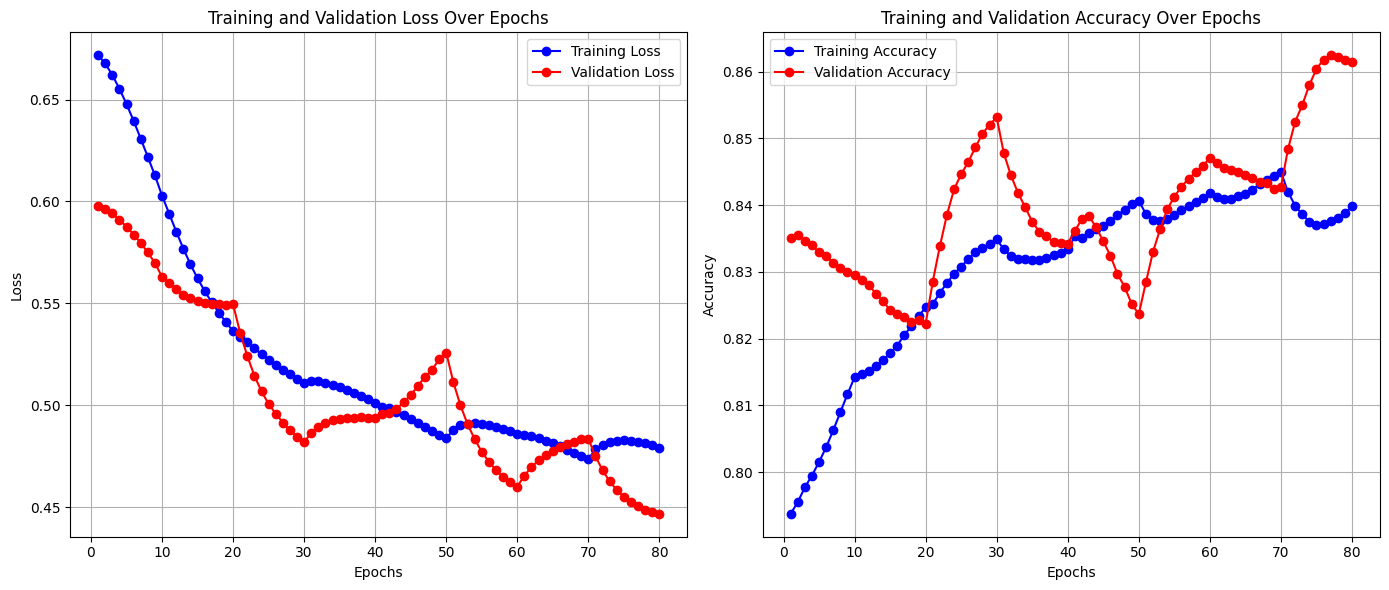

In [16]:
# Define the number of epochs for plotting
epochs = range(1, len(all_scores['loss']) + 1)

# Function to smooth the data for better visualization (optional)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Create a figure for plotting with better visualization settings
plt.figure(figsize=(14, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, smooth_curve(all_scores['loss']), 'bo-', label='Training Loss')
plt.plot(epochs, smooth_curve(all_scores['val_loss']), 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, smooth_curve(all_scores['accuracy']), 'bo-', label='Training Accuracy')
plt.plot(epochs, smooth_curve(all_scores['val_accuracy']), 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()



Evaluate the training on the testing dataset, Which is the last batch of the the 10th simulation in the file
The log the testing validation and loss alongside the F1,

In [17]:
# Set the simulation index
i = 10

# Create an ImaFile object for the specified simulation folder and model
file_sim = ImaFile(simulations_folder=path_sim + 'IW/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')

# Read the simulation data with the specified parameter and maximum number of replicates
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

# Filter the simulations based on a frequency threshold of 0.01
gene_sim_test.filter_freq(0.01)

# Sort the simulations by row frequency
gene_sim_test.sort('rows_freq')

# Resize the simulation data to the specified dimensions (198, 192)
gene_sim_test.resize((198, 192))

# Convert the simulation data with data augmentation (flip=True)
gene_sim_test.convert(flip=True)

# Get a random subset of indices and subset the simulation data
rnd_idx = get_index_random(gene_sim_test)  # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

# Convert the targets to binary format
gene_sim_test.targets = to_binary(gene_sim_test.targets)


In [18]:

net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(net_LCT.test) # it will report [loss, accuracy]


[0.4548356235027313, 0.8502500057220459]


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


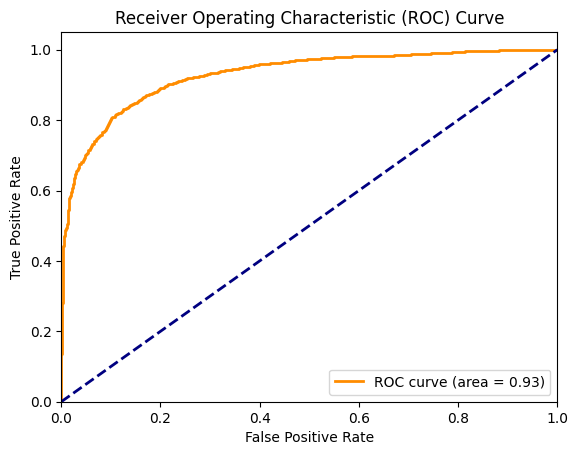

F1 Score: 0.8499123026810322
Precision: 0.8518332496233049
Recall (Sensitivity): 0.848


In [19]:
# Make predictions on the validation data
predictions = model.predict(gene_sim_test.data)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, predictions.round())

# Calculate precision, recall, and F-score
precision, recall, fscore, _ = precision_recall_fscore_support(gene_sim_test.targets, predictions.round(), average='binary')

# Recall is equivalent to sensitivity
sensitivity = recall

# Compute ROC curve and AUC (Area Under the Curve)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print additional metrics
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall (Sensitivity): {sensitivity}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


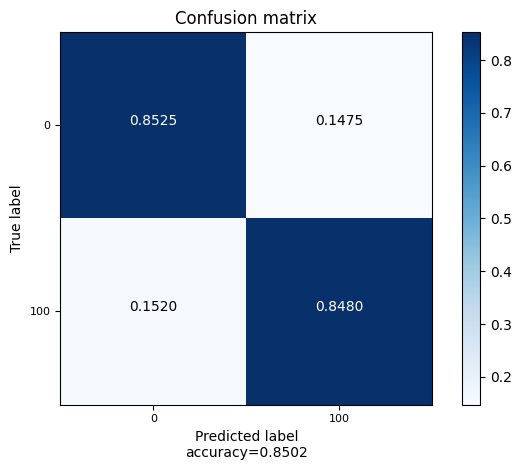

0

In [20]:
# Make predictions on the test data using the trained model and store the results in net_LCT
net_LCT.predict(gene_sim_test, model)

# Plot the confusion matrix of the predictions against the true classes, with text labels for clarity
net_LCT.plot_cm(gene_sim_test.classes, text=True)


In [21]:
path = './'
filename = 'IW_Baseline.keras'

# Save the trained model to a file using the recommended Keras format
model.save(path + filename)
#Model saved to Google Drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path and filename
path = '/content/drive/My Drive/models/'
filename = 'IW_Baseline.keras'

# Save the trained model to the specified path
model.save(path + filename)


Mounted at /content/drive
